Actual: fracture, Predicted: groove
Actual: fracture, Predicted: breakdown
Actual: fracture, Predicted: groove
Actual: fracture, Predicted: groove
Actual: fracture, Predicted: breakdown
Actual: fracture, Predicted: fracture
Copied correctly classified image to: /Users/prashantronad/Documents/College/5thsemEL/AeBAD/Test_images/fracture/IMG_9390.png
Actual: fracture, Predicted: fracture
Copied correctly classified image to: /Users/prashantronad/Documents/College/5thsemEL/AeBAD/Test_images/fracture/IMG_9353.png
Actual: fracture, Predicted: ablation
Actual: fracture, Predicted: ablation
Actual: fracture, Predicted: groove
Actual: fracture, Predicted: groove
Actual: fracture, Predicted: good
Actual: fracture, Predicted: groove
Actual: fracture, Predicted: fracture
Copied correctly classified image to: /Users/prashantronad/Documents/College/5thsemEL/AeBAD/Test_images/fracture/IMG_9387.png
Actual: fracture, Predicted: fracture
Copied correctly classified image to: /Users/prashantronad/Documen

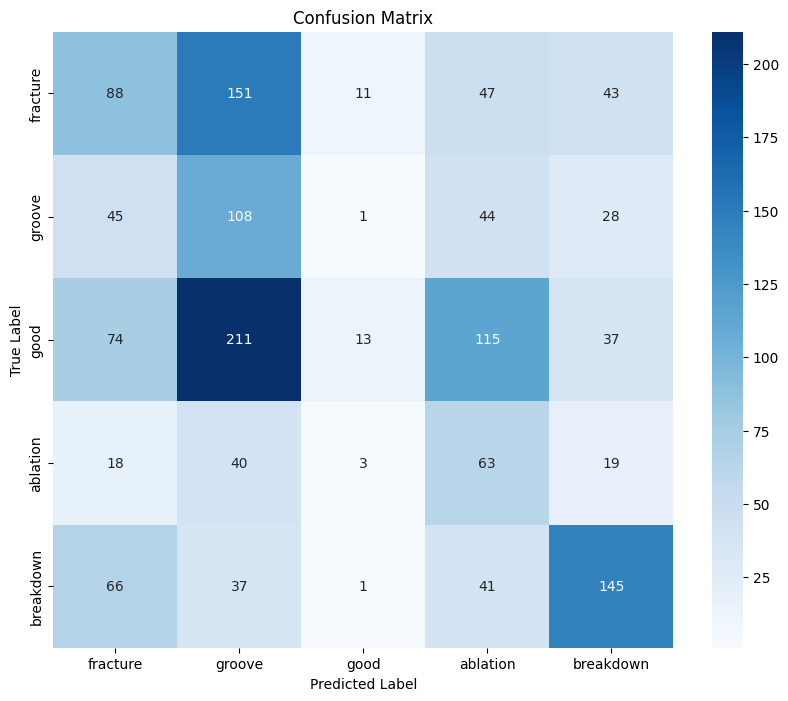

In [1]:
import os
import base64
import time
import shutil
from groq import Groq
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Initialize the Groq client with your API key
client = Groq(api_key="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")

# Class labels
class_labels = ["fracture", "groove", "good", "ablation", "breakdown"]

# Function to ensure output directory exists
def create_output_directories(base_path):
    for label in class_labels:
        os.makedirs(os.path.join(base_path, label), exist_ok=True)

# Track request timestamps to enforce rate limit
request_timestamps = deque()
RATE_LIMIT = 29  # Max 29 requests per minute
RATE_TIMEFRAME = 60  # 60 seconds

def enforce_rate_limit():
    current_time = time.time()
    while request_timestamps and (current_time - request_timestamps[0]) > RATE_TIMEFRAME:
        request_timestamps.popleft()
    
    if len(request_timestamps) >= RATE_LIMIT:
        sleep_time = RATE_TIMEFRAME - (current_time - request_timestamps[0]) + 1  # +1 buffer
        print(f"Rate limit reached. Sleeping for {sleep_time:.2f} seconds...")
        time.sleep(sleep_time)
    
    request_timestamps.append(time.time())

# Function to classify the image and return the predicted class
def classify_image(image_path):
    try:
        enforce_rate_limit()  # Ensure we don't exceed API limits
        base64_image = encode_image(image_path)

        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": (
                            "I am analyzing images of aircraft engine blades. Please classify the image into one of the following categories based on visible damage: "
                            "1. **Ablation**: Loss of material due to erosion or wear, usually represented by blackened or scorched areas, typically seen as small regions of surface damage."
                            "2. **Breakdown**: Holes or significant damage in the blade structure, indicating severe stress or material failure."
                            "3. **Fracture**: Loss or cutting out of part of the blade, usually seen as cracks or chunks missing from the edges."
                            "4. **Groove**: Shallow cuts or indentations along the surface of the blade, often caused by external factors or friction."
                            "5. **Good**: No visible damage, wear, or defects, with the blade in perfect working condition."
                            "Classify this aircraft engine blade image into exactly one of these categories: ablation, breakdown, fracture, groove, good. "
                            "Respond with only the category name in lowercase, nothing else."
                        )},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
                    ],
                }
            ],
            model="llama-3.2-11b-vision-preview",
        )

        prediction = chat_completion.choices[0].message.content.lower().strip()
        return prediction if prediction in class_labels else None

    except Exception as e:
        print(f"Error with image {image_path}: {e}. Skipping this image.")
        return None

# Function to loop through images and classify them
def evaluate_model(test_folder, output_base_path):
    y_true = []  # True labels
    y_pred = []  # Predicted labels
    create_output_directories(output_base_path)
    
    for label in class_labels:
        folder_path = os.path.join(test_folder, label)
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            for image_name in os.listdir(subfolder_path):
                if not image_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue
                
                image_path = os.path.join(subfolder_path, image_name)
                true_label = label
                y_true.append(true_label)
                predicted_label = classify_image(image_path)

                if predicted_label is not None:
                    y_pred.append(predicted_label)
                    print(f"Actual: {true_label}, Predicted: {predicted_label}")
                    if true_label == predicted_label:
                        output_path = os.path.join(output_base_path, predicted_label, image_name)
                        shutil.copy2(image_path, output_path)
                        print(f"Copied correctly classified image to: {output_path}")
                else:
                    y_pred.append('skipped')

    return y_true, y_pred

# Paths
test_folder_path = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test"
output_base_path = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/Test_images"

# Evaluate the model
y_true, y_pred = evaluate_model(test_folder_path, output_base_path)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=class_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [1]:
!pip install fvcore

Defaulting to user installation because normal site-packages is not writeable
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached iopath-0.1.10-py3-none-any.whl
  Using cached portalocker-3.1.1-py3-none-any.whl.metadata (8.6 kB)
Using cached termcolor-2.5.0-py3-none-any.whl (7.8 kB)
Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached portalocker-3.1.1-py3-none-any.whl (19 kB)


In [2]:
import torch
checkpoint = torch.load("checkpoints/aebad_S_AeBAD_S_MMR_model.pth", map_location="cpu")
print(checkpoint.keys())


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_6035/2756022378.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/aebad_S_A

dict_keys(['cur_model_state_dict', 'mmr_base_state_dict', 'optimizer_state_dict', 'cfg'])


In [6]:
!pip install timm
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_image-0.24.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (14 kB)
  Using cached tifffile-2024.8.30-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.24.0-cp39-cp39-macosx_12_0_arm64.whl (13.4 MB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2024.8.30-py3-none-any.whl (227 kB)


In [5]:
# Import required libraries
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter
from functools import partial
import matplotlib.pyplot as plt

# Import your model classes - adjust these imports based on your project structure
import sys
sys.path.append('./')  # Add project root to path
from models.MMR.MMR import MMR_base
from models.MMR.utils import ForwardHook, cal_anomaly_map
from config import get_cfg

# Initialize the anomaly detector
class AnomalyDetector:
    def __init__(self, checkpoint_path, config_path):
        # Load configuration
        self.cfg = get_cfg()
        self.cfg.merge_from_file(config_path)
        
        # Set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize models
        self.cur_model = self._init_current_model()
        self.mmr_model = self._init_mmr_model(checkpoint_path)
        
        # Register hooks
        self.teacher_outputs_dict = {}
        for extract_layer in self.cfg.TRAIN.MMR.layers_to_extract_from:
            forward_hook = ForwardHook(self.teacher_outputs_dict, extract_layer)
            network_layer = self.cur_model.__dict__["_modules"][extract_layer]
            network_layer[-1].register_forward_hook(forward_hook)
        
        # Define image transforms
        self.transform = transforms.Compose([
            transforms.Resize(self.cfg.DATASET.resize),
            transforms.CenterCrop(self.cfg.DATASET.imagesize),
            transforms.ToTensor(),
        ])

    def _init_current_model(self):
        try:
            print("Initializing WideResNet50 model...")
            model = models.wide_resnet50_2(pretrained=True)
            model.to(self.device)
            model.eval()
            print("WideResNet50 model initialized successfully")
            return model
        except Exception as e:
            raise Exception(f"Failed to initialize current model: {str(e)}")

    def _init_mmr_model(self, checkpoint_path: str):
        try:
            # Initialize the MMR base model
            model = MMR_base(cfg=self.cfg)

            # Load the checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=self.device)

            # Load the correct state dictionary
            model.load_state_dict(checkpoint['mmr_base_state_dict'])

            # Send the model to the appropriate device and set to evaluation mode
            model.to(self.device)
            model.eval()
            print("MMR model initialized successfully")
            return model
        except Exception as e:
            print(f"Error details: {str(e)}")
            raise Exception(f"Failed to initialize MMR model: {str(e)}")


    def detect(self, image_path, threshold=0.4):
        """
        Detect anomalies in a single image
        Args:
            image_path: Path to the image file
            threshold: Anomaly threshold (0-1)
        Returns:
            anomaly_score: Overall anomaly score
            anomaly_map: 2D numpy array of anomaly scores
            is_anomaly: Boolean indicating if anomaly was detected
        """
        try:
            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                # Get current model features
                self.teacher_outputs_dict.clear()
                _ = self.cur_model(image_tensor)
                multi_scale_features = [self.teacher_outputs_dict[key] 
                                      for key in self.cfg.TRAIN.MMR.layers_to_extract_from]
                
                # Get MMR features
                reverse_features = self.mmr_model(image_tensor, 
                                               mask_ratio=self.cfg.TRAIN.MMR.test_mask_ratio)
                multi_scale_reverse_features = [reverse_features[key] 
                                              for key in self.cfg.TRAIN.MMR.layers_to_extract_from]
                
                # Calculate anomaly map
                anomaly_map, _ = cal_anomaly_map(
                    multi_scale_features, 
                    multi_scale_reverse_features, 
                    image_tensor.shape[-1],
                    amap_mode='a'
                )
                
                # Apply Gaussian smoothing
                anomaly_map = gaussian_filter(anomaly_map[0], sigma=4)
                
                # Calculate anomaly score
                anomaly_score = np.max(anomaly_map)
                is_anomaly = anomaly_score > threshold
                
                return {
                    'anomaly_score': float(anomaly_score),
                    'anomaly_map': anomaly_map,
                    'is_anomaly': bool(is_anomaly),
                    'original_image': image
                }
        except Exception as e:
            raise Exception(f"Error during detection: {str(e)}")

    def visualize_result(self, result):
        """
        Visualize the detection result
        Args:
            result: Dictionary containing detection results
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot original image
        ax1.imshow(result['original_image'])
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot anomaly map
        im = ax2.imshow(result['anomaly_map'], cmap='jet')
        ax2.set_title(f"Anomaly Map\nScore: {result['anomaly_score']:.3f}")
        ax2.axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=ax2)
        plt.tight_layout()
        plt.show()

# Create detector instance
detector = AnomalyDetector(
    checkpoint_path="checkpoints/aebad_S_AeBAD_S_MMR_model.pth",
    config_path="method_config/AeBAD_S/MMR.yaml"
)



/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Initializing WideResNet50 model...


/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


WideResNet50 model initialized successfully


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_36410/581795970.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

MMR model initialized successfully


In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from models.MMR import MMR_base
from models.MMR.utils import cal_anomaly_map
from config import get_cfg

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the model
def load_model(model_path, cfg):
    # Initialize the MMR model
    model = MMR_base(cfg=cfg)
    
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    
    # Load the state dict
    model.load_state_dict(checkpoint['mmr_base_state_dict'])
    
    model.eval()
    return model

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Inference function
def inference(model, image_path, cfg):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        
        # Debug: Print the model's output to understand its structure
        print("Model outputs:", outputs)
        
        # Check if outputs are in the expected format
        if not isinstance(outputs, list) or len(outputs) == 0:
            raise ValueError("Model output is not in the expected format. Ensure it returns a list of feature maps.")
        
        # Assuming outputs contain feature maps for anomaly detection
        anomaly_map, _ = cal_anomaly_map(outputs, outputs, out_size=224)
        anomaly_score = np.mean(anomaly_map)
        
        # Determine predicted class based on anomaly score
        if anomaly_score > cfg.THRESHOLD:
            predicted_class = "anomalous"
        else:
            predicted_class = "normal"
        
    return predicted_class, anomaly_score

# Test a single image
cfg = get_cfg()
cfg.THRESHOLD = 0.5  # Set an appropriate threshold for anomaly detection
model_path = '/Users/prashantronad/Documents/College/5thsemEL/aebad_S_AeBAD_S_MMR_model.pth'
image_path = '/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test/fracture/view/IMG_9591.png'

# Load the model
model = load_model(model_path, cfg)

# Perform inference on the single image
predicted_class, anomaly_score = inference(model, image_path, cfg)
print(f"Predicted Class: {predicted_class}, Anomaly Score: {anomaly_score}")

/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_36410/294894076.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

Model outputs: {'layer1': tensor([[[[ 8.4020e-02,  9.7096e-02,  4.6866e-02,  ..., -6.3993e-02,
            8.3646e-02,  5.8416e-02],
          [ 1.1122e-01,  1.9600e-01,  1.5257e-01,  ...,  1.1016e-02,
            1.1844e-01,  1.1153e-01],
          [ 6.0737e-05,  8.4281e-02,  8.5315e-02,  ..., -4.6466e-02,
            2.6300e-02,  4.8882e-02],
          ...,
          [ 1.0487e-02,  9.4450e-02,  7.1138e-02,  ...,  7.7117e-02,
            1.6724e-01,  1.6520e-01],
          [ 2.2378e-02,  1.3623e-01,  1.0255e-01,  ...,  1.0613e-01,
            2.2701e-01,  2.0766e-01],
          [ 5.7691e-02,  2.0899e-01,  1.5331e-01,  ...,  1.8996e-01,
            3.2315e-01,  2.1214e-01]],

         [[ 6.5603e-01,  6.9890e-01,  7.9116e-01,  ...,  5.8169e-01,
            6.8502e-01,  5.2261e-02],
          [ 9.5221e-01,  8.1969e-01,  9.2844e-01,  ...,  6.3365e-01,
            8.0319e-01,  2.0499e-01],
          [ 8.9679e-01,  7.3995e-01,  8.3435e-01,  ...,  6.1689e-01,
            7.7575e-01,  1.6948e

ValueError: Model output is not in the expected format. Ensure it returns a list of feature maps.

NameError: name 'outputs' is not defined

In [10]:
import glob
import os
from collections import defaultdict

# Define directories for test images
base_directory = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test/"
categories = {
    "good": "good",  # Good images
    "ablation": "ablation",  # Anomaly: Ablation
    "breakdown": "breakdown",  # Anomaly: Breakdown
    "fracture": "fracture",  # Anomaly: Fracture
    "groove": "groove",  # Anomaly: Groove
}

conditions = ["background", "illumination", "same", "view"]

# Initialize results storage
overall_results = defaultdict(list)

# Function to process and detect anomalies in images from a specific directory
def process_directory(detector, category, condition):
    print(f"\nProcessing {category.capitalize()} images under '{condition}' condition...")
    image_directory = os.path.join(base_directory, category, condition)
    image_paths = glob.glob(os.path.join(image_directory, "*.png"))
    
    if not image_paths:
        print(f"No images found in {image_directory}")
        return
    
    print(f"Found {len(image_paths)} images.")
    
    for image_path in image_paths:
        print(f"Processing image: {os.path.basename(image_path)}")
        try:
            # Detect anomaly for the current image
            result = detector.detect(image_path)
            
            # Print results for the image
            print(f"  Anomaly Score: {result['anomaly_score']:.3f}")
            print(f"  Is Anomaly: {result['is_anomaly']}")
            
            # Store the result
            overall_results[category].append({
                "image_path": image_path,
                "anomaly_score": result['anomaly_score'],
                "is_anomaly": result['is_anomaly'],
            })
            
            # Visualize the result
            detector.visualize_result(result)
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")

# Loop through all categories and conditions
for category, folder in categories.items():
    for condition in conditions:
        process_directory(detector, folder, condition)

# Print overall summary
print("\n=== Overall Summary ===")
for category, results in overall_results.items():
    print(f"\nCategory: {category.capitalize()}")
    for res in results:
        print(f"  Image: {os.path.basename(res['image_path'])}, "
              f"Anomaly Score: {res['anomaly_score']:.3f}, Is Anomaly: {res['is_anomaly']}")



Processing Good images under 'background' condition...
Found 93 images.
Processing image: IMG_8138.png
  Anomaly Score: 0.368
  Is Anomaly: False


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_36410/581795970.py:153: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Processing image: IMG_7753.png
  Anomaly Score: 0.422
  Is Anomaly: True
Processing image: IMG_7747.png
  Anomaly Score: 0.393
  Is Anomaly: False
Processing image: IMG_7784.png
  Anomaly Score: 0.424
  Is Anomaly: True
Processing image: IMG_7800.png
  Anomaly Score: 0.475
  Is Anomaly: True
Processing image: IMG_7785.png
  Anomaly Score: 0.469
  Is Anomaly: True
Processing image: IMG_7791.png
  Anomaly Score: 0.418
  Is Anomaly: True
Processing image: IMG_7752.png
  Anomaly Score: 0.391
  Is Anomaly: False
Processing image: IMG_8139.png
  Anomaly Score: 0.360
  Is Anomaly: False
Processing image: IMG_7778.png
  Anomaly Score: 0.382
  Is Anomaly: False
Processing image: IMG_7744.png
  Anomaly Score: 0.423
  Is Anomaly: True
Processing image: IMG_7787.png
  Anomaly Score: 0.382
  Is Anomaly: False
Processing image: IMG_7793.png
  Anomaly Score: 0.382
  Is Anomaly: False
Processing image: IMG_7786.png
  Anomaly Score: 0.424
  Is Anomaly: True
Processing image: IMG_7751.png
  Anomaly Scor

/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_36410/581795970.py:138: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


  Anomaly Score: 0.456
  Is Anomaly: True
Processing image: IMG_7797.png
  Anomaly Score: 0.487
  Is Anomaly: True
Processing image: IMG_7783.png
  Anomaly Score: 0.392
  Is Anomaly: False
Processing image: IMG_7768.png
  Anomaly Score: 0.392
  Is Anomaly: False
Processing image: IMG_7754.png
  Anomaly Score: 0.360
  Is Anomaly: False
Processing image: IMG_7740.png
  Anomaly Score: 0.460
  Is Anomaly: True
Processing image: IMG_8117.png
  Anomaly Score: 0.375
  Is Anomaly: False
Processing image: IMG_8129.png
  Anomaly Score: 0.351
  Is Anomaly: False
Processing image: IMG_7756.png
  Anomaly Score: 0.388
  Is Anomaly: False
Processing image: IMG_7742.png
  Anomaly Score: 0.423
  Is Anomaly: True
Processing image: IMG_7795.png
  Anomaly Score: 0.401
  Is Anomaly: True
Processing image: IMG_7781.png
  Anomaly Score: 0.392
  Is Anomaly: False
Processing image: IMG_7780.png
  Anomaly Score: 0.365
  Is Anomaly: False
Processing image: IMG_7794.png
  Anomaly Score: 0.482
  Is Anomaly: True
P

KeyboardInterrupt: 

In [5]:
# Print overall summary with details
print("\n=== Overall Summary ===")
category_summary = defaultdict(lambda: defaultdict(lambda: {"anomalous": 0, "non_anomalous": 0}))

for category, results in overall_results.items():
    print(f"\nCategory: {category.capitalize()}")
    for res in results:
        image_name = os.path.basename(res['image_path'])
        anomaly_status = "Anomalous" if res['is_anomaly'] else "Non-Anomalous"
        print(f"  Image: {image_name}, Anomaly Score: {res['anomaly_score']:.3f}, Is Anomaly: {res['is_anomaly']}")

        # Update category and condition summary
        condition = os.path.basename(os.path.dirname(res['image_path']))  # Get condition (e.g., background, view)
        if res['is_anomaly']:
            category_summary[category][condition]["anomalous"] += 1
        else:
            category_summary[category][condition]["non_anomalous"] += 1

# Print detailed summary
print("\n=== Anomalous vs Non-Anomalous Summary ===")
for category, conditions in category_summary.items():
    print(f"\nCategory: {category.capitalize()}")
    for condition, counts in conditions.items():
        print(f"  Condition: {condition.capitalize()}")
        print(f"    Anomalous: {counts['anomalous']}")
        print(f"    Non-Anomalous: {counts['non_anomalous']}")



=== Overall Summary ===

Category: Good
  Image: IMG_7766.png, Anomaly Score: 0.406, Is Anomaly: True
  Image: IMG_7795.png, Anomaly Score: 0.401, Is Anomaly: True
  Image: IMG_7738.png, Anomaly Score: 0.383, Is Anomaly: False
  Image: IMG_7740.png, Anomaly Score: 0.460, Is Anomaly: True
  Image: IMG_7758.png, Anomaly Score: 0.360, Is Anomaly: False
  Image: IMG_7787.png, Anomaly Score: 0.382, Is Anomaly: False
  Image: IMG_8129.png, Anomaly Score: 0.351, Is Anomaly: False
  Image: IMG_7776.png, Anomaly Score: 0.364, Is Anomaly: False
  Image: IMG_8145.png, Anomaly Score: 0.354, Is Anomaly: False
  Image: IMG_7737.png, Anomaly Score: 0.382, Is Anomaly: False
  Image: IMG_7779.png, Anomaly Score: 0.384, Is Anomaly: False
  Image: IMG_7765.png, Anomaly Score: 0.336, Is Anomaly: False
  Image: IMG_8120.png, Anomaly Score: 0.382, Is Anomaly: False
  Image: IMG_7748.png, Anomaly Score: 0.327, Is Anomaly: False
  Image: IMG_8139.png, Anomaly Score: 0.360, Is Anomaly: False
  Image: IMG_7786

#CLASSIFICATION

In [18]:
# Import additional required libraries
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from typing import Dict, Any, Tuple
from config import get_cfg
from models.MMR.MMR import MMR_base
from models.MMR.utils import ForwardHook, cal_anomaly_map

class AnomalyDetector:
    def __init__(self, checkpoint_path, config_path):
        # Load configuration
        self.cfg = get_cfg()
        self.cfg.merge_from_file(config_path)
        
        # Set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize models
        self.cur_model = self._init_current_model()
        self.mmr_model = self._init_mmr_model(checkpoint_path)
        
        # Register hooks
        self.teacher_outputs_dict = {}
        for extract_layer in self.cfg.TRAIN.MMR.layers_to_extract_from:
            forward_hook = ForwardHook(self.teacher_outputs_dict, extract_layer)
            network_layer = self.cur_model.__dict__["_modules"][extract_layer]
            network_layer[-1].register_forward_hook(forward_hook)
        
        # Define image transforms
        self.transform = transforms.Compose([
            transforms.Resize((self.cfg.DATASET.resize, self.cfg.DATASET.resize)),
            transforms.CenterCrop(self.cfg.DATASET.imagesize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])

        # Define category thresholds
        self.category_thresholds = {
            'breakdown': 0.72,  # Slightly higher than current due to high confidence
            'ablation': 0.57,   # Increased slightly as it's a more subtle defect
            'groove': 0.58,     # Increased to reduce false positives
            'fracture': 0.55    # Slightly increased as fractures can be subtle
        }
        
        # Define pattern weights
        self.pattern_weights = {
            'breakdown': {'size': 0.4, 'intensity': 0.6},
            'ablation': {'size': 0.3, 'intensity': 0.7},
            'groove': {'size': 0.6, 'intensity': 0.4},
            'fracture': {'size': 0.5, 'intensity': 0.5}
        }

    # ... rest of the class implementation remains the same ...
    def _init_current_model(self):
        """Initialize the WideResNet50 model"""
        try:
            print("Initializing WideResNet50 model...")
            model = models.wide_resnet50_2(pretrained=True)
            model.to(self.device)
            model.eval()
            print("WideResNet50 model initialized successfully")
            return model
        except Exception as e:
            raise Exception(f"Failed to initialize current model: {str(e)}")

    def _init_mmr_model(self, checkpoint_path: str):
        """Initialize the MMR model"""
        try:
            # Initialize the MMR base model
            model = MMR_base(cfg=self.cfg)

            # Load the checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=self.device)

            # Load the correct state dictionary
            model.load_state_dict(checkpoint['mmr_base_state_dict'])

            # Send the model to the appropriate device and set to evaluation mode
            model.to(self.device)
            model.eval()
            print("MMR model initialized successfully")
            return model
        except Exception as e:
            print(f"Error details: {str(e)}")
            raise Exception(f"Failed to initialize MMR model: {str(e)}")





    def analyze_anomaly_pattern(self, anomaly_map: np.ndarray) -> Dict[str, float]:
        """
        Analyze the anomaly map to extract pattern characteristics
        """
        # Calculate pattern metrics
        intensity = np.mean(anomaly_map[anomaly_map > np.mean(anomaly_map)])
        size = np.sum(anomaly_map > np.mean(anomaly_map)) / anomaly_map.size
        
        # Calculate pattern scores for each category
        scores = {}
        for category, weights in self.pattern_weights.items():
            score = (
                weights['size'] * size +
                weights['intensity'] * intensity
            )
            scores[category] = score
            
        return scores

    def detect(self, image_path: str, threshold: float = 0.4) -> Dict[str, Any]:
        """
        Detect and classify anomalies in a single image
        """
        try:
            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                # Get features and calculate anomaly map (existing code)
                self.teacher_outputs_dict.clear()
                _ = self.cur_model(image_tensor)
                multi_scale_features = [self.teacher_outputs_dict[key] 
                                      for key in self.cfg.TRAIN.MMR.layers_to_extract_from]
                
                reverse_features = self.mmr_model(image_tensor, 
                                               mask_ratio=self.cfg.TRAIN.MMR.test_mask_ratio)
                multi_scale_reverse_features = [reverse_features[key] 
                                              for key in self.cfg.TRAIN.MMR.layers_to_extract_from]
                
                anomaly_map, _ = cal_anomaly_map(
                    multi_scale_features, 
                    multi_scale_reverse_features, 
                    image_tensor.shape[-1],
                    amap_mode='a'
                )
                
                # Apply Gaussian smoothing
                anomaly_map = gaussian_filter(anomaly_map[0], sigma=4)
                
                # Calculate overall anomaly score
                anomaly_score = float(np.max(anomaly_map))
                is_anomaly = anomaly_score > threshold
                
                # If anomalous, determine the specific category
                category = 'normal'
                category_scores = {}
                if is_anomaly:
                    # Analyze pattern characteristics
                    pattern_scores = self.analyze_anomaly_pattern(anomaly_map)
                    
                    # Calculate category scores combining pattern analysis and thresholds
                    for cat, base_threshold in self.category_thresholds.items():
                        category_scores[cat] = pattern_scores[cat] * (anomaly_score / base_threshold)
                    
                    # Select category with highest score
                    if category_scores:
                        category = max(category_scores.items(), key=lambda x: x[1])[0]
                
                return {
                    'anomaly_score': anomaly_score,
                    'anomaly_map': anomaly_map,
                    'is_anomaly': is_anomaly,
                    'category': category,
                    'category_scores': category_scores,
                    'original_image': image
                }
        except Exception as e:
            raise Exception(f"Error during detection: {str(e)}")

    def visualize_result(self, result: Dict[str, Any]) -> None:
        """
        Visualize the detection result with category information
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot original image
        ax1.imshow(result['original_image'])
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot anomaly map
        im = ax2.imshow(result['anomaly_map'], cmap='jet')
        title = f"Anomaly Map\nScore: {result['anomaly_score']:.3f}\n"
        title += f"Category: {result['category']}"
        
        # Add category scores if available
        if result['category_scores']:
            title += "\n\nCategory Scores:"
            for cat, score in result['category_scores'].items():
                title += f"\n{cat}: {score:.3f}"
                
        ax2.set_title(title)
        ax2.axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=ax2)
        plt.tight_layout()
        plt.show()


In [13]:
# Create detector instance
detector = AnomalyDetector(
    checkpoint_path="checkpoints/aebad_S_AeBAD_S_MMR_model.pth",
    config_path="method_config/AeBAD_S/MMR.yaml"
)

# Test on an image
result = detector.detect("/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test/fracture/illumination/IMG_9704.png")
print(f"Anomaly Score: {result['anomaly_score']:.3f}")
print(f"Category: {result['category']}")
print("\nCategory Scores:")
for cat, score in result['category_scores'].items():
    print(f"{cat}: {score:.3f}")

# Visualize results
detector.visualize_result(result)

Using device: cpu
Initializing WideResNet50 model...


/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


WideResNet50 model initialized successfully


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_17184/3409810442.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

MMR model initialized successfully
Anomaly Score: 0.575
Category: ablation

Category Scores:
breakdown: 0.400
ablation: 0.452
groove: 0.447
fracture: 0.423


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_17184/3409810442.py:206: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [3]:
# Let's examine the checkpoint content
checkpoint_path = "checkpoints/aebad_S_AeBAD_S_MMR_model.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Print the keys in the checkpoint
print("Checkpoint contains the following keys:")
print(checkpoint.keys())

# Let's examine the model architecture and configuration
print("\nConfiguration details:")
if 'cfg' in checkpoint:
    print(checkpoint['cfg'])

# Examine the state dict keys to understand model's output layers
print("\nModel state dict keys:")
if 'mmr_base_state_dict' in checkpoint:
    for key in checkpoint['mmr_base_state_dict'].keys():
        print(key)

/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_17184/4124930897.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Checkpoint contains the following keys:
dict_keys(['cur_model_state_dict', 'mmr_base_state_dict', 'optimizer_state_dict', 'cfg'])

Configuration details:
DATASET:
  domain_shift_category: view
  imagesize: 224
  name: aebad_S
  resize: 256
  subdatasets: ['AeBAD_S']
NUM_GPUS: 1
OUTPUT_DIR: ./log_MMR_AeBAD_S_54
RNG_SEED: 54
SAVE_DIR: ./checkpoints
TEST:
  VISUALIZE:
    Random_sample: True
    Sample_num: 40
  dataset_path: /home/rvce/Downloads/aircraft/AeBAD
  enable: True
  method: MMR
  pixel_mode_verify: True
  save_segmentation_images: True
  save_video_segmentation_images: False
TEST_SETUPS:
  batch_size: 32
TRAIN:
  MMR:
    DA_low_limit: 0.7
    DA_up_limit: 1.0
    FPN_output_dim: (256, 512, 1024)
    feature_compression: False
    finetune_mask_ratio: 0.4
    layers_to_extract_from: ['layer1', 'layer2', 'layer3']
    load_pretrain_model: True
    model_chkpt: /home/rvce/Downloads/aircraft/mae_visualize_vit_base.pth
    scale_factors: (4.0, 2.0, 1.0)
    test_mask_ratio: 0.0
  

In [19]:
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# Define categories and conditions
categories = ['good', 'ablation', 'breakdown', 'fracture', 'groove']
conditions = ['background', 'illumination', 'same', 'view']

# Function to get random samples from each category
# Function to get all samples from each category
def get_all_samples(base_path, category):
    all_images = []
    for condition in conditions:
        path = Path(base_path) / category / condition
        images = list(path.glob('*.png'))
        all_images.extend(images)
    return all_images
# Initialize results storage
results_data = []
base_path = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test"

# Process images from each category
for category in categories:
    print(f"\nProcessing {category} images...")
    sample_images = get_all_samples(base_path, category)
    
    for img_path in sample_images:
        try:
            # Get condition from path
            condition = img_path.parent.name
            
            # Detect anomalies
            result = detector.detect(str(img_path))
            
            # Store results
            results_data.append({
                'image_path': str(img_path),
                'true_category': category,
                'predicted_category': result['category'],
                'condition': condition,
                'anomaly_score': result['anomaly_score'],
                'is_anomaly': result['is_anomaly'],
                'category_scores': result['category_scores'] if result['category_scores'] else None
            })
            
            print(f"Processed: {img_path.name}")
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert results to DataFrame
df = pd.DataFrame(results_data)

# Calculate metrics
print("\n=== Analysis Results ===")

# Average anomaly scores by category
avg_scores = df.groupby('true_category')['anomaly_score'].agg(['mean', 'std']).round(3)
print("\nAverage Anomaly Scores by Category:")
print(avg_scores)

# Confusion Matrix
y_true = df['true_category']
y_pred = df['predicted_category']
conf_matrix = confusion_matrix(y_true, y_pred, labels=categories)
conf_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)
print("\nConfusion Matrix:")
print(conf_df)

# Classification Report
class_report = classification_report(y_true, y_pred, labels=categories)
print("\nClassification Report:")
print(class_report)

# Accuracy by condition
condition_accuracy = df.groupby('condition').apply(
    lambda x: (x['true_category'] == x['predicted_category']).mean()
).round(3)
print("\nAccuracy by Condition:")
print(condition_accuracy)

# Save detailed results to CSV
df.to_csv('anomaly_detection_results.csv', index=False)
print("\nDetailed results saved to 'anomaly_detection_results.csv'")

# Calculate suggested thresholds based on average scores
print("\nSuggested category thresholds (based on mean + 0.5*std):")
for category in categories[1:]:  # Exclude 'good' category
    category_scores = df[df['true_category'] == category]['anomaly_score']
    suggested_threshold = (category_scores.mean() + 0.5 * category_scores.std()).round(3)
    print(f"{category}: {suggested_threshold}")


Processing good images...
Processed: IMG_8138.png
Processed: IMG_7753.png
Processed: IMG_7747.png
Processed: IMG_7784.png
Processed: IMG_7800.png
Processed: IMG_7785.png
Processed: IMG_7791.png
Processed: IMG_7752.png
Processed: IMG_8139.png
Processed: IMG_7778.png
Processed: IMG_7744.png
Processed: IMG_7787.png
Processed: IMG_7793.png
Processed: IMG_7786.png
Processed: IMG_7751.png
Processed: IMG_7745.png
Processed: IMG_7779.png
Processed: IMG_8116.png
Processed: IMG_7741.png
Processed: IMG_7755.png
Processed: IMG_7769.png
Processed: IMG_7782.png
Processed: IMG_7796.png
Processed: IMG_7797.png
Processed: IMG_7783.png
Processed: IMG_7768.png
Processed: IMG_7754.png
Processed: IMG_7740.png
Processed: IMG_8117.png
Processed: IMG_8129.png
Processed: IMG_7756.png
Processed: IMG_7742.png
Processed: IMG_7795.png
Processed: IMG_7781.png
Processed: IMG_7780.png
Processed: IMG_7794.png
Processed: IMG_7743.png
Processed: IMG_7757.png
Processed: IMG_8128.png
Processed: IMG_7730.png
Processed: IM

/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


Accuracy: 41.88%

Per-class metrics:

ablation:
Precision: 72.15%
Recall: 46.34%
F1-score: 56.44%

breakdown:
Precision: 93.51%
Recall: 38.92%
F1-score: 54.96%

fracture:
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%

good:
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%

groove:
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%


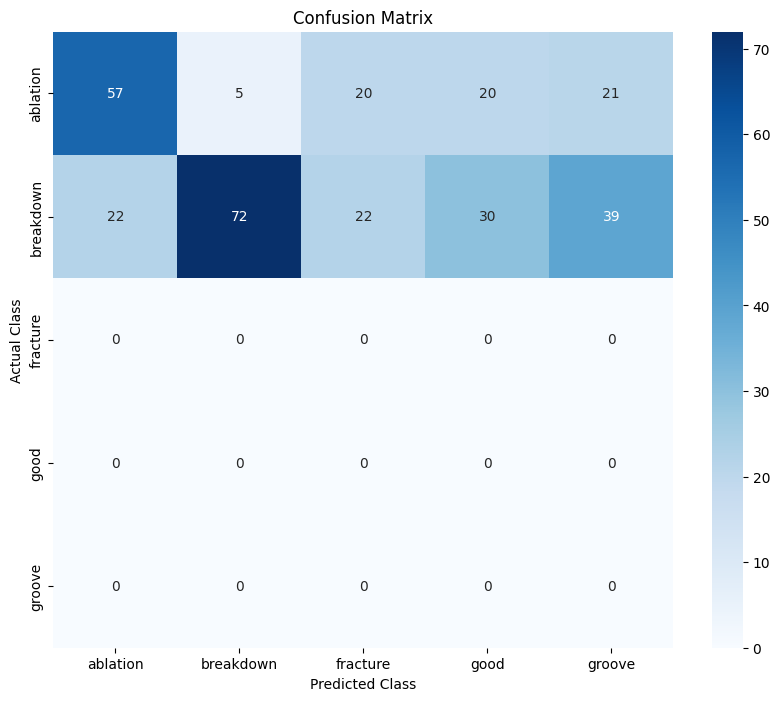

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create the lists again
actual = ['ablation'] * 124 + ['breakdown'] * 186
predicted = ['ablation', 'fracture', 'ablation', 'fracture', 'ablation', 'groove', 'ablation', 'ablation', 
            'breakdown', 'groove', 'fracture', 'groove', 'good', 'good', 'good', 'ablation', 'fracture',
            'groove', 'ablation', 'ablation', 'fracture', 'good', 'ablation', 'groove', 'ablation', 'groove',
            'good', 'ablation', 'ablation', 'groove', 'groove', 'ablation', 'fracture', 'fracture', 'ablation',
            'ablation', 'ablation', 'good', 'fracture', 'fracture', 'ablation', 'groove', 'ablation', 'good',
            'good', 'groove', 'groove', 'good', 'ablation', 'good', 'groove', 'good', 'ablation', 'ablation',
            'ablation', 'ablation', 'ablation', 'ablation', 'good', 'fracture', 'good', 'fracture', 'ablation',
            'groove', '4', 'fracture', 'fracture', 'groove', 'groove', 'ablation', 'ablation', 'ablation',
            'ablation', 'groove', 'ablation', 'ablation', 'ablation', 'ablation', 'groove', 'ablation',
            'breakdown', 'breakdown', 'ablation', 'ablation', 'ablation', 'good', 'ablation', 'breakdown',
            'ablation', 'groove', 'groove', 'fracture', 'fracture', 'good', 'fracture', 'ablation', 'good',
            'good', 'ablation', 'groove', 'ablation', 'ablation', 'ablation', 'fracture', 'good', 'ablation',
            'fracture', 'ablation', 'ablation', 'ablation', 'good', 'groove', 'ablation', 'fracture',
            'ablation', 'ablation', 'ablation', 'ablation', 'ablation', 'fracture', 'breakdown', 'ablation',
            'ablation', 'good', 'groove', 'good', 'groove', 'groove', 'groove', 'groove', 'ablation',
            'breakdown', 'groove', 'ablation', 'breakdown', 'ablation', 'groove', 'groove', 'breakdown',
            'ablation', 'ablation', 'fracture', 'ablation', 'good', 'ablation', 'ablation', 'ablation',
            'ablation', 'ablation', 'fracture', 'ablation', 'good', 'groove', 'groove', 'groove', 'good',
            'groove', 'ablation', 'good', 'ablation', 'fracture', 'ablation', 'fracture', 'ablation', 'good',
            'groove', '3', 'ablation', 'fracture', 'good', 'breakdown', 'breakdown', 'breakdown', 'groove',
            'breakdown', 'breakdown', 'good', 'fracture', 'breakdown', 'groove', 'groove', 'breakdown',
            'breakdown', 'breakdown', 'groove', 'breakdown', 'ablation', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'breakdown', 'fracture', 'breakdown', 'breakdown', 'breakdown', 'ablation',
            'breakdown', 'groove', 'breakdown', 'breakdown', 'fracture', 'groove', 'breakdown', 'breakdown',
            'groove', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'ablation', 'breakdown', 'groove', 'breakdown', 'breakdown', 'breakdown', 'ablation',
            'groove', 'breakdown', 'groove', 'breakdown', 'groove', 'fracture', 'fracture', 'groove',
            'breakdown', 'fracture', 'good', 'good', 'groove', 'breakdown', 'good', 'groove', 'good',
            'groove', 'breakdown', 'breakdown', 'good', 'good', 'groove', 'groove', 'breakdown', 'breakdown',
            'good', 'good', 'breakdown', 'fracture', 'breakdown', 'good', 'groove', 'groove', 'good',
            'breakdown', 'breakdown', 'breakdown', 'breakdown', 'ablation', 'breakdown', 'fracture', 'groove',
            'good', 'breakdown', 'good', 'good', 'good', 'breakdown', 'breakdown', 'breakdown', 'fracture',
            'fracture', 'breakdown', 'good', 'fracture', 'breakdown', 'good', 'good', 'fracture', 'good',
            'groove', 'groove', 'fracture', 'groove', 'good', 'good', 'breakdown', 'fracture', 'breakdown',
            'breakdown', 'good', 'groove', 'fracture', 'fracture', 'breakdown', 'good', 'breakdown',
            'groove', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'fracture', 'groove', 'breakdown',
            'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'groove',
            'breakdown', 'breakdown', 'fracture', 'breakdown', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'breakdown', 'breakdown', 'breakdown', 'fracture', 'breakdown', 'breakdown',
            'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'breakdown', 'ablation', 'breakdown', 'breakdown', 'groove', 'fracture', 'good',
            'breakdown', 'fracture', 'good', 'breakdown', 'breakdown', 'groove', 'ablation', 'breakdown',
            'breakdown', 'breakdown', 'groove', 'breakdown', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'groove', 'breakdown', 'breakdown', 'groove', 'breakdown', 'groove', 'ablation',
            'breakdown', 'breakdown', 'breakdown', 'groove', 'good', 'breakdown', 'good', 'groove', 'good',
            'groove', 'good', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'fracture',
            'breakdown', 'groove', 'breakdown', 'good', 'good', 'good', 'fracture', 'breakdown', 'fracture',
            'breakdown', 'good', 'fracture', 'groove', 'good', 'breakdown', 'groove', 'fracture', 'good',
            'groove', 'breakdown', 'groove', 'breakdown', 'ablation', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'groove', 'breakdown', 'breakdown', 'ablation', '2', 'groove', 'groove', 'groove',
            'breakdown', 'good', 'groove', '2', 'groove', 'fracture', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'groove', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'groove',
            'breakdown', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'groove', 'breakdown',
            'breakdown', 'breakdown', 'groove', 'breakdown', 'breakdown', 'breakdown', 'breakdown',
            'breakdown', 'groove', 'breakdown', 'breakdown', 'groove', 'breakdown', 'groove', 'good',
            'ablation', 'good', 'breakdown', 'breakdown', 'breakdown', 'breakdown', 'fracture', 'good',
            'breakdown', 'fracture', 'groove', 'groove', 'breakdown', 'groove', 'groove', 'breakdown',
            'fracture', 'groove', 'breakdown', 'breakdown', 'groove', 'breakdown', 'breakdown', 'breakdown',
            'good', 'ablation', 'breakdown', 'good', 'good', 'breakdown', 'breakdown', 'breakdown', 'breakdown']

# Remove any numeric predictions and their corresponding actual values
cleaned_data = [(a, p) for a, p in zip(actual, predicted) if not p.isdigit()]
actual_cleaned, predicted_cleaned = zip(*cleaned_data)

# Get unique labels (sorted to ensure consistent order)
labels = sorted(set(actual_cleaned) | set(predicted_cleaned))

# Create confusion matrix
cm = confusion_matrix(actual_cleaned, predicted_cleaned, labels=labels)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\nAccuracy: {accuracy:.2%}")

# Calculate per-class metrics
print("\nPer-class metrics:")
for i, label in enumerate(labels):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"\n{label}:")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-score: {f1:.2%}")

Using device: cpu


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_36410/3503717286.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

<Figure size 640x480 with 0 Axes>

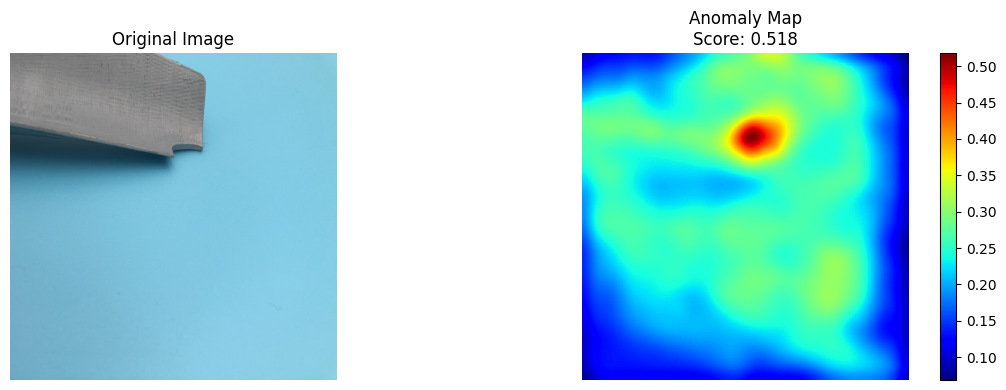

Anomaly Score: 0.518
Is Anomaly: True


In [17]:
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


# Import your model classes - adjust these imports based on your project structure
import sys
sys.path.append('./')  
from models.MMR.MMR import MMR_base
from models.MMR.utils import ForwardHook, cal_anomaly_map
from config import get_cfg

def detect_single_image(image_path, checkpoint_path, config_path, threshold=0.4):
    """
    Detect anomalies in a single image using the AeBAD model
    
    Args:
        image_path (str): Path to the input image
        checkpoint_path (str): Path to the model checkpoint
        config_path (str): Path to the model configuration file
        threshold (float): Anomaly detection threshold (0-1)
        
    Returns:
        dict: Detection results including anomaly score, map, and visualization
    """
    # Load configuration
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize current model (WideResNet50)
    cur_model = models.wide_resnet50_2(pretrained=True)
    cur_model.to(device)
    cur_model.eval()
    
    # Initialize MMR model
    mmr_model = MMR_base(cfg=cfg)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    mmr_model.load_state_dict(checkpoint['mmr_base_state_dict'])
    mmr_model.to(device)
    mmr_model.eval()
    
    # Register hooks
    teacher_outputs_dict = {}
    for extract_layer in cfg.TRAIN.MMR.layers_to_extract_from:
        forward_hook = ForwardHook(teacher_outputs_dict, extract_layer)
        network_layer = cur_model.__dict__["_modules"][extract_layer]
        network_layer[-1].register_forward_hook(forward_hook)
    
    # Define image transforms
    transform = transforms.Compose([
        transforms.Resize(cfg.DATASET.resize),
        transforms.CenterCrop(cfg.DATASET.imagesize),
        transforms.ToTensor(),
    ])
    
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Get current model features
        teacher_outputs_dict.clear()
        _ = cur_model(image_tensor)
        multi_scale_features = [teacher_outputs_dict[key] 
                              for key in cfg.TRAIN.MMR.layers_to_extract_from]
        
        # Get MMR features
        reverse_features = mmr_model(image_tensor, 
                                   mask_ratio=cfg.TRAIN.MMR.test_mask_ratio)
        multi_scale_reverse_features = [reverse_features[key] 
                                      for key in cfg.TRAIN.MMR.layers_to_extract_from]
        
        # Calculate anomaly map
        anomaly_map, _ = cal_anomaly_map(
            multi_scale_features, 
            multi_scale_reverse_features, 
            image_tensor.shape[-1],
            amap_mode='a'
        )
        
        # Apply Gaussian smoothing
        anomaly_map = gaussian_filter(anomaly_map[0], sigma=4)
        
        # Calculate final results
        anomaly_score = np.max(anomaly_map)
        is_anomaly = anomaly_score > threshold
        
        # Clear any existing plots
        plt.clf()
        
        # Create new figure with specified DPI for better resolution
        fig = plt.figure(figsize=(12, 4), dpi=100)
        
        # Plot original image
        ax1 = plt.subplot(1, 2, 1)
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot anomaly map
        ax2 = plt.subplot(1, 2, 2)
        im = ax2.imshow(anomaly_map, cmap='jet')
        ax2.set_title(f"Anomaly Map\nScore: {anomaly_score:.3f}")
        ax2.axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=ax2)
        
        # Adjust layout and display
        plt.tight_layout()
        
        # For Jupyter notebook
        plt.show()
        
        return {
            'anomaly_score': float(anomaly_score),
            'anomaly_map': anomaly_map,
            'is_anomaly': bool(is_anomaly),
            'figure': fig  # Return the figure object for further manipulation if needed
        }

# Example usage

    # Replace these paths with your actual paths
image_path = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test/fracture/view/IMG_9596.png"
checkpoint_path = "checkpoints/aebad_S_AeBAD_S_MMR_model.pth"
config_path = "method_config/AeBAD_S/MMR.yaml"

# Run detection
result = detect_single_image(image_path, checkpoint_path, config_path)

# Print results
print(f"Anomaly Score: {result['anomaly_score']:.3f}")
print(f"Is Anomaly: {result['is_anomaly']}")